Given presentation is not actually done uniformly, switch to a training regimen more closely resembling the experiment:

- **Presentation Block**: all pairs are presented once
- **Learning block 1**: fan 1 pairs are presented twice, fan 2 pairs 5 times. (order randomized)
- **Learning block 2,3,4**: fan 1 pairs are presented once, fan 2 pairs twice.

Jelmer also used surprising parameters, including:
- Intercepts uniformly distributed between 0. and .1
- 512 Dimensions
- 1k neurons

However, via repeated experiments, none of these parameters appear to be important.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes
from nengo_learn_assoc_mem.learning_rules.fake_voja import FakeVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple
from typing import List

import random

In [2]:
class MaxMixed(FakeVoja):

    def __init__(self, encoders: np.ndarray, bias: float, post_tau=0.005, learning_rate=1e-3, radius=1.):
        super().__init__(encoders, post_tau, learning_rate)
        self.radius = radius
        self.bias = bias

    def encode(self, t):
        # highly reacting neurons: 1000-500 = 500
        # low reacting neurons: 1-500 = -499, ie switches learning around
        # problem is tons of zeros, so let's assume it knows the max

        threshold = self.bias * np.max(self.acts)

        lr = self.enabled * self.learning_rate
        delta = lr * (self.acts[:, None] - threshold) * (self.encoders - self.in_sig)
        mod_enc = self.encoders + delta
        mag = np.linalg.norm(mod_enc, axis=1)
        self.encoders = self.radius / mag[:, None] * mod_enc

        if (t / self.dt % self.period) < 1:
            self.encoder_hist.append(self.encoders.copy())

        return np.dot(self.encoders, self.in_sig)

# Setup

In [3]:
n_items = 16
dimensions = 32
n_neurons = 500

dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [4]:
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)

intercepts = .2 * np.ones(n_neurons)

In [5]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [6]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [45]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

# Train

In [46]:
def learn_encoders(feed_vecs: List[np.array], start_enc: np.array, voja_lr=5e-8) -> np.array:
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

    with nengolib.Network(seed=seed) as model:
        in_nd = nengo.Node(feed.feed)
        nvoja_learn = nengo.Node(lambda t: 1-feed.paused)
        paused = nengo.Node(lambda t: feed.paused)

        neg_voja = MaxMixed(enc.copy(), 0.2, learning_rate=voja_lr)
        ens = nengo.Ensemble(n_neurons, dimensions, seed=seed)

        nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

        nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
        nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
        nengo.Connection(nvoja_learn, neg_voja.enable, synapse=None)
        nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    with nengo.Simulator(model) as sim:
        sim.run(len(feed_vecs)*t_each + t_pause)
    
    return neg_voja.encoder_hist[-1].copy()

In [47]:
def shuffle_list(li: List):
    return sorted(li, key=lambda k: random.random())

In [48]:
all_feed_vecs = (
    fan1_pair_vecs + fan2_pair_vecs,
    shuffle_list(fan1_pair_vecs * 2 + fan2_pair_vecs * 5),
    shuffle_list(fan1_pair_vecs + fan2_pair_vecs * 3),
    shuffle_list(fan1_pair_vecs + fan2_pair_vecs * 3),
    shuffle_list(fan1_pair_vecs + fan2_pair_vecs * 3))

In [49]:
for f_v in all_feed_vecs:
    enc = learn_encoders(f_v, enc, voja_lr=-1e-6/5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## Verification

In [50]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts, seed=seed)
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [51]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

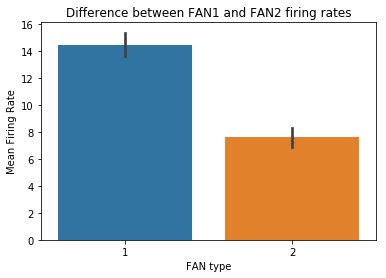

In [52]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

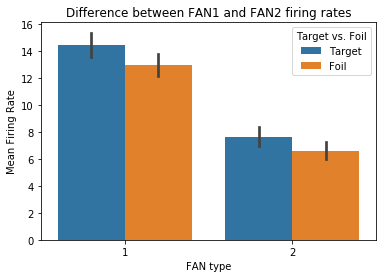

In [53]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

# Association

## Analytically

In [16]:
targ_vecs = np.array(fan1_pair_vecs + fan2_pair_vecs)

In [17]:
_, fan_acts = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=targ_vecs)

In [18]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decs, res = solver(fan_acts, targ_vecs)

In [19]:
dec_vecs = np.dot(fan_acts, decs)
new_rmse = nengo.utils.numpy.rmse(dec_vecs, targ_vecs, axis=0)
np.allclose(res["rmses"], new_rmse)

True

In [20]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
    dec_vecs = np.dot(act, decs)
    err = nengo.utils.numpy.rmse(dec_vecs, obj.vecs, axis=0)

    flat_err = list(err)
    resp = [obj.fan_num] * len(flat_err)
    targ = [obj.targ] * len(flat_err)
    df_list.append(pd.DataFrame({"err": flat_err, "resp": resp, "targ": targ}))

err_df = pd.concat(df_list)

Text(0.5,0,'FAN type')

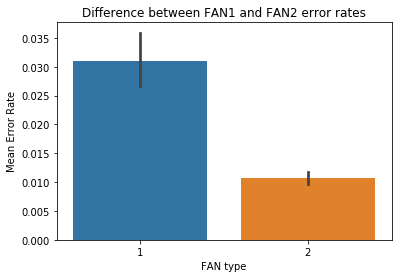

In [21]:
ax = sns.barplot(x="resp", y="err", hue_order=(True, False), data=err_df[err_df.targ==True])

ax.set_title("Difference between FAN1 and FAN2 error rates")
ax.set_ylabel("Mean Error Rate")
ax.set_xlabel("FAN type")

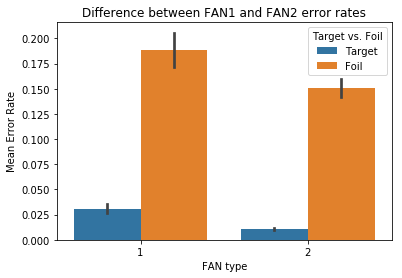

In [22]:
ax = sns.barplot(x="resp", y="err", hue="targ", hue_order=(True, False), data=err_df)

ax.set_title("Difference between FAN1 and FAN2 error rates")
ax.set_ylabel("Mean Error Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

## PES

In [98]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [99]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [100]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [101]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=enc, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    conn_out = nengo.Connection(ens.neurons, output, transform=np.zeros((dimensions, n_neurons)),
                                learning_rule_type=nengo.PES(2e-2))
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

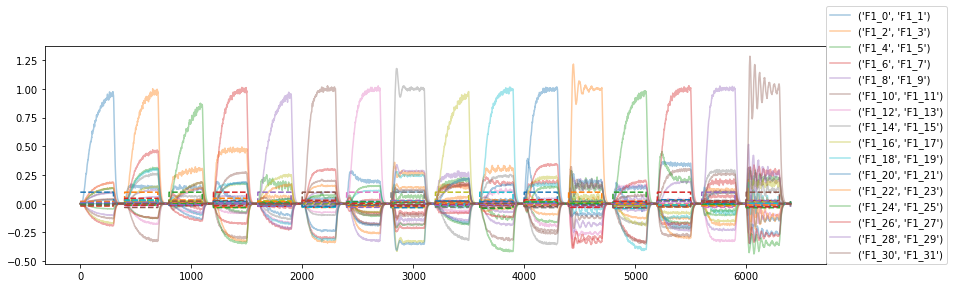

In [102]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

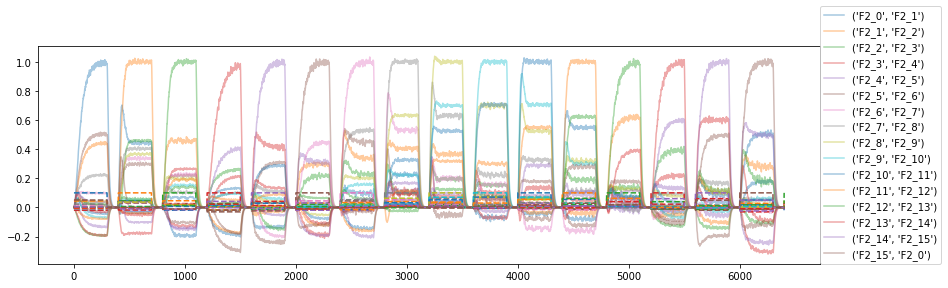

In [103]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

In [104]:
dec = learned_sim.data[p_dec][-1]
dec.shape

(32, 500)

# Test

In [105]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=enc, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

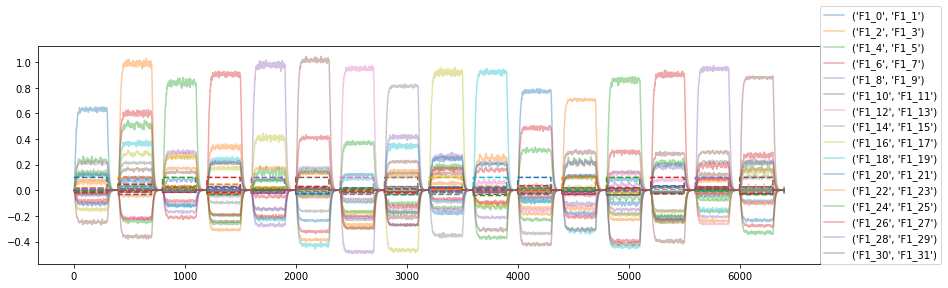

In [106]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

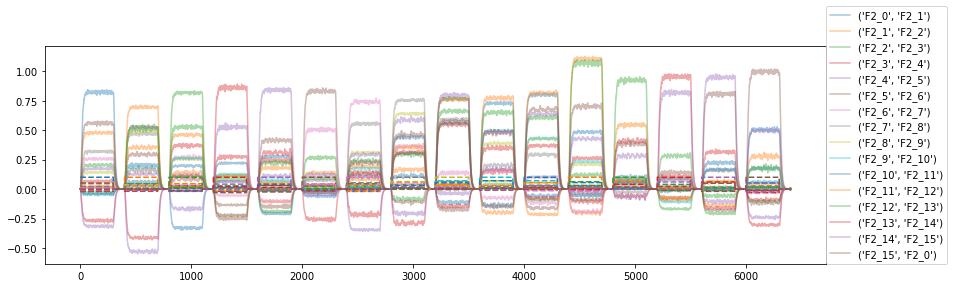

In [107]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

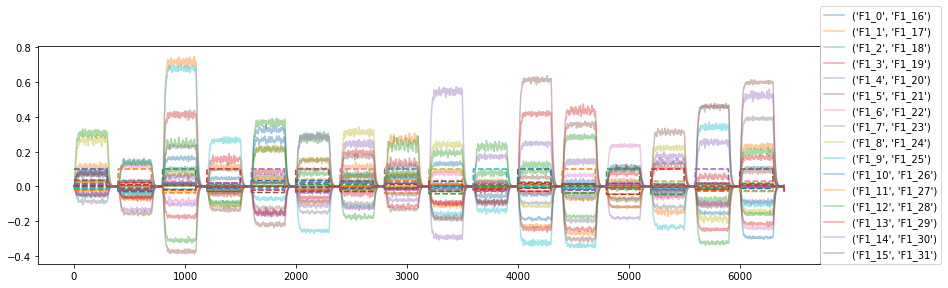

In [108]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs)*0.1, linestyle="--")
plt.legend(foil1, loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [109]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [110]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [111]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [112]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[186.341271   293.83310774 248.51007143 268.95834681 291.11760168
 300.7329631  282.15107846 242.00431505 272.30043455 272.89446701
 229.3390954  209.949497   254.97226696 268.692999   280.76401132
 261.69857056]
260.26625606716243


In [113]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [114]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 30 27 27 27 28 29 30 31]
[244.39055986 207.25616264 243.47717414 255.82347042 249.63850996
 247.10152583 219.86248429 224.58890022 237.65930337 230.36072024
 243.16484625 328.86158896 273.96024622 283.21124225 282.07971266
 296.40079278]
254.23982750520423


## Compare reaction times

In [115]:
def ans_conf(ans: np.ndarray, cor: np.ndarray, num_items: int, td_item: int):
    ind_ans = np.sum(ans*cor, axis=1).reshape((td_item, num_items, -1), order='F')
    conf = np.max(np.sum(ind_ans, axis=0), axis=1)
    return conf

In [116]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [117]:
confs = {}

for nm, obj in slc_stim_vecs.items():
    conf_res = ans_conf(
        test_sim.data[p_out][obj.slc],
        test_sim.data[p_cor][obj.slc],
        len(obj.vecs), td_each
    )
    confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 246.19876644629156
fan2 234.93979862659378
foil1 107.292279218792
foil2 156.85356458376083


In [118]:
conf_df = pd.DataFrame(confs)

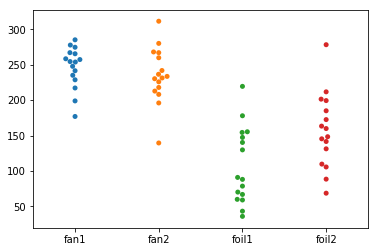

In [119]:
sns.swarmplot(data=conf_df)

Learning with recurrence works from decoding function 0, but never fully differentiating FAN1 vs FAN2. learning without recurrence does a worse job of seperating foils from targets. Learning from initial decoding works really poorly. Increasing dimensionality makes it harder to distinguish targets from foils.